# Movie Recommender Case Study

Today you are going to have a little friendly competition with your classmates.

You are going to building a recommendation system based off data from the
[MovieLens dataset](http://grouplens.org/datasets/movielens/). It includes movie
information, user information, and the users' ratings. Your goal is to build a
recommendation system and to suggest movies to users!

The **movies data** and **user data** are in `data/movies.dat` and `data/users.dat`.

The **ratings data** can be found in `data/training.csv`. The users' ratings have been broken into a training and test set for you (to obtain the testing set, we have split the 20% of **the most recent** ratings).

In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
ratings_df = pd.read_csv('data/training.csv')
ratings_df = ratings_df.drop(columns = 'timestamp')

In [3]:
ratings_df.describe()

,user,movie,rating
count,800000.000000,800000.000000,800000.000000
mean,3403.097837,1849.257256,3.590479
std,1546.589028,1086.852485,1.120376
min,636.000000,1.000000,1.000000
25%,2035.000000,1028.000000,3.000000
50%,3507.000000,1788.000000,4.000000
75%,4695.000000,2750.000000,4.000000
max,6040.000000,3952.000000,5.000000


# Apply ratings table filters.
- This will help to reduce the sparseness and may allow us to get better predictions from the ALS.


## *Thumbs up* filter
- Delete movies that almost no one has rated highly.
- 3662 total movies in training data. 
- Drop 1319 duds (i.e. 99.7% of ratings < 4.7). 
- Yields 2204 movies.

In [4]:
# Group movies by rating and get their mean and std ratings. Alternatively, we could count the number of 5's. Drop if less than 5%.
movie = ratings_df.groupby('movie').agg(mean = ('rating', 'mean'), std= ('rating','std'))
movie.head(2)

,mean,std
movie,,
1,4.145226,0.858766
2,3.197880,0.979288


In [5]:
# 99.7% of ratings below 4.7
movie['stat_score'] = movie['mean'] + 1.5 * movie['std']
low_rate = movie[movie['stat_score'] < 4.7]
movie[movie['stat_score'] < 4.7].count()

mean          1319
std           1319
stat_score    1319
dtype: int64

In [6]:
thumbs_up = movie[movie['stat_score'] >= 4.7]
thumbs_up = thumbs_up.drop(columns=['std','mean'])
thumbs_up.count()

stat_score    2204
dtype: int64

In [7]:
thumbs_up.head(2)

,stat_score
movie,
1,5.433374
6,5.264844


In [8]:
# Apply 'thumbs up' filter to ratings data table
thumbs_up_ratings = ratings_df.merge(thumbs_up, how='inner', left_on='movie', right_on='movie')

In [9]:
thumbs_up_ratings.head(2)

,user,movie,rating,stat_score
0,6040,858,4,5.712651
1,6037,858,5,5.712651


## *Too few ratings* filter
- Trim movies if less than 15 ratings
- Drop 266 low review counts. 
- Yields 1938 movies.

In [10]:
low_count_ratings = thumbs_up_ratings.groupby('movie').count()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08115b6c10>]],
      dtype=object)

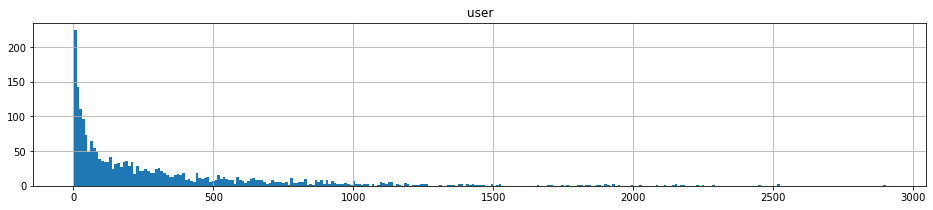

In [11]:
low_count_ratings.hist('user', bins=300, figsize=(16,3))

In [12]:
low_count = low_count_ratings[low_count_ratings['user'] < 15]
low_count_ratings[low_count_ratings['user'] < 15].count()

user          266
rating        266
stat_score    266
dtype: int64

In [13]:
good_count_ratings = low_count_ratings[low_count_ratings['user']>= 15].reset_index()

In [14]:
good_count_ratings = good_count_ratings.drop(['user', 'rating', 'stat_score'], axis = 1)

In [15]:
good_count_ratings.count()

movie    1938
dtype: int64

In [16]:
two_filter_ratings = thumbs_up_ratings.merge(good_count_ratings, how='inner', left_on='movie', right_on='movie')

In [17]:
two_filter_ratings.head()

,user,movie,rating,stat_score
0,6040,858,4,5.712651
1,6037,858,5,5.712651
2,6033,858,4,5.712651
3,6028,858,4,5.712651
4,6026,858,4,5.712651


In [18]:
two_filter_ratings.count()

user          642509
movie         642509
rating        642509
stat_score    642509
dtype: int64

In [19]:
two_filter_ratings.to_csv('data/two_filter_ratings.csv')

# Create a bad movie drop filter

In [20]:
good_movies = two_filter_ratings.groupby('movie').count()

In [312]:
all_movies = ratings_df.groupby('movie').count()

In [313]:
all_movies.head()

,user,rating
movie,,
1,1749,1749
2,566,566
3,382,382
4,134,134
5,237,237


In [331]:
null_set = all_movies.merge(good_movies, how='outer', left_on='movie', right_on='movie')

In [332]:
null_set

,user_x,rating_x,user_y,rating_y,stat_score
movie,,,,,
1,1749,1749,1749.0,1749.0,1749.0
2,566,566,NaN,NaN,NaN
3,382,382,NaN,NaN,NaN
4,134,134,NaN,NaN,NaN
5,237,237,NaN,NaN,NaN
...,...,...,...,...,...
3948,450,450,450.0,450.0,450.0
3949,76,76,76.0,76.0,76.0
3950,15,15,15.0,15.0,15.0


In [334]:
null = null_set[null_set.isnull().any(axis=1)]

In [336]:
null.columns

Index(['user_x', 'rating_x', 'user_y', 'rating_y', 'stat_score'], dtype='object')

In [339]:
null = null.drop(['user_x', 'rating_x', 'user_y', 'rating_y', 'stat_score'], axis = 1)

In [340]:
null.to_csv('data/movies_to_drop.csv')